In [2]:
import pandas as pd
import numpy as np
import utilssphering
import os
import matplotlib.pyplot as plt
import glob
import utils

In [57]:
# merge experiment and fov metadata DFs together. Update some fields to the data is present in both DFs
# This should only have to be run once to collate all the metadata together

fov = pd.read_csv("output/FoV-experiment-metadata.tsv", sep="\t").drop(columns=("Batch")).rename(columns={"FoV_Batch": "Batch"})

orig = pd.read_csv('output/experiment-metadata-updated.csv')
comb = pd.concat([fov, orig], ignore_index=True)
comb["sites"] = comb["Sites-SubSampled"]
comb["sites"].fillna(comb["Images_per_well"], inplace=True)
comb["sites"] = comb["sites"].astype(int)
comb["Sites-SubSampled"] = comb["Sites-SubSampled"].astype("Int64")
# Add dry values for 0.45 and 0.75 apertures
comb.loc[(comb["aperture"] == 0.45) | (comb["aperture"] == 0.75), "dry-immersion"] = "dry"

# Add aperture information to siteSubSubsampled data
no_ap = comb[comb["Batch"].str.contains("siteSub")]
ap = comb[~comb["Batch"].str.contains("siteSub")]
for i, row in no_ap.iterrows():
    barcode = row["Assay_Plate_Barcode"]
    no_ap.loc[i, "aperture"] = ap[ap["Assay_Plate_Barcode"] == barcode]["aperture"].values[0]
    no_ap.loc[i, "dry-immersion"] = ap[ap["Assay_Plate_Barcode"] == barcode]["dry-immersion"].values[0]
comb = pd.concat([ap, no_ap])

# Drop remnants of indexes gone by and other old columns
comb = comb.loc[:,~comb.columns.str.contains("Unnamed:|Anomaly")]

filesize_metadata = pd.read_csv("output/all-profile-metadata-INCLUDING-FILESIZES.csv")
# Add filesize metadata
comb = comb.merge(filesize_metadata[["Size_MB", "Size_MB_std", "Batch", "Assay_Plate_Barcode"]], on=["Batch", "Assay_Plate_Barcode"])

# Save df
comb.to_csv("output/all-profile-metadata.csv", index=False)

# Read new experiment df
experiment_df = pd.read_csv("output/all-profile-metadata.csv")
experiment_df


,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,z_plane,BF_Zplanes,spinning-disc,aperture,dry-immersion,vs-brightfield,simultaneous-excitation,sites,Size_MB,Size_MB_std
0,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,NaN,1,10,6,1,NaN,no,0.45,dry,NaN,NaN,4,52.476334,0.000144
1,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,NaN,1,10,6,1,NaN,yes,0.45,dry,NaN,NaN,4,52.476514,0.000183
2,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,NaN,1,10,6,3,NaN,yes,0.45,dry,NaN,NaN,4,52.476631,0.000142
3,MolDev,Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,4,NaN,1,20,6,3,NaN,yes,0.75,dry,NaN,NaN,4,52.476629,0.000114
4,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Confocal,9,NaN,1,20,6,1,NaN,no,0.75,dry,NaN,NaN,9,52.476334,0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch,JUMP-MOA_compound_platemap,BRO0117056_20x,Confocal,9,4.0,1,20,5,12,13,NaN,1.00,water,NaN,NaN,4,8.003585,0.000044
180,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_5Ch_12Z,JUMP-MOA_compound_platemap,BRO0117056_20xb,Confocal,9,4.0,1,20,5,12,15,NaN,1.00,water,NaN,NaN,4,8.003585,0.000044
181,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,4.0,1,20,6,12,15,NaN,1.00,water,NaN,NaN,4,7.954439,0.000583
182,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,4.0,1,20,6,12,15,NaN,1.00,water,NaN,NaN,4,8.003584,0.000014


In [91]:

update_cols = [
    "Modality",
    "Binning",
    "Magnification",
    "Number_of_channels",
    "z_plane",
    "BF_Zplanes",
    "spinning-disc",
    "aperture",
    "dry-immersion",
    "vs-brightfield",
    "simultaneous-excitation"
]

def propagate_metadata(source_df, destination_df, metadata_cols):
    """
    Propagate metadata information from the original metadata file
    (source_df) to all site subsampled data (destination_df)
    """

    sour_df = source_df.copy()
    dest_df = destination_df.copy()

    # Wipe all metadata values in the destination_df
    dest_df.loc[:, metadata_cols] = np.nan

    # Iterate through the DF to have settings added
    for i, row in dest_df.iterrows():
        # Get the unique barcode
        barcode = row["Assay_Plate_Barcode"]
        for col in metadata_cols:
            # For the index in the dest_df, match the row with the source_df based on 
            # Assay_Plate_Barcode, then update the value. Multiple rows (ie subsamples) will
            # match with one barcode
            dest_df.loc[i, col] = sour_df[sour_df["Assay_Plate_Barcode"] == barcode][col].values[0]
    
    out_df = pd.concat([sour_df, dest_df])
    # Columns that contain data that should be represented as type int
    int_metadata = ["Binning", "Magnification", "Number_of_channels", "z_plane", "BF_Zplanes"]
    # Int64 to allow for nullable integers
    # Columns that contain NaN will be reconverted to float when loaded again, without some
    # custom loading
    out_df[int_metadata] = out_df[int_metadata].astype(pd.Int64Dtype())
    return out_df

comb = pd.read_csv("output/all-profile-metadata.csv")
comb = comb.drop(comb.columns[comb.columns.str.contains('unnamed',case = False)],axis=1) # drop pesky unnamed columns if you forgot index=False
df_1 = comb[~comb["Batch"].str.contains("siteSub")]
df_2 = comb[comb["Batch"].str.contains("siteSub")]
out_df = propagate_metadata(df_1, df_2, update_cols)

out_df.to_csv("output/all-profile-metadata.csv", index=False)

In [92]:
out_df.columns

Index(['Vendor', 'Batch', 'Plate_Map_Name', 'Assay_Plate_Barcode', 'Modality',
       'Images_per_well', 'Sites-SubSampled', 'Binning', 'Magnification',
       'Number_of_channels', 'z_plane', 'BF_Zplanes', 'spinning-disc',
       'aperture', 'dry-immersion', 'vs-brightfield',
       'simultaneous-excitation', 'sites', 'Size_MB', 'Size_MB_std',
       'channel_names', 'brightfield_z_plane_used', 'feature_channels_found'],
      dtype='object')

In [ ]:
def update_metadata(new_metdata_df, old_metadata_df, merge_cols):
    """
    Update the metadata of an old DF for a given set of columns

    Keep the original values of non-update columns

    Used for keeping percent replicating, but updating metadata
    """
    new_df = new_metdata_df.copy()
    old_df = old_metadata_df.copy()
    # Find the set of column names that are not merge columns
    new_cols = set(new_df.loc[:, ~new_df.columns.str.contains("|".join(merge_cols))].columns)
    old_cols = set(old_df.loc[:, ~old_df.columns.str.contains("|".join(merge_cols))].columns)
    # Find the intersection of column names between new and old
    drop_cols = new_cols.intersection(old_cols)
    # Drop intersection and keep others (such as Percent_Replicating)
    old_df = old_df.drop(drop_cols, axis=1)

    # Drop the old cols to be updated
    # old_df = old_df.drop(update_cols, axis=1)

    out_df = pd.merge(new_df, old_df, on=merge_cols)
    return out_df


df1 = pd.read_csv("output/all-profile-metadata.csv")
df2 = pd.read_csv("checkpoints/match_rep_df.csv")
out = update_metadata(df1, df2, ["Vendor", "Batch", "Assay_Plate_Barcode"])
out.to_csv("checkpoints/match_rep_df.csv", index=False)

In [48]:
import logging
logging.basicConfig(filename="./log")

def create_moa_dataframe(experiment_metadata, profile_parent_dir, batch_col="Batch", match_or_rep_or_both="replicating", enable_sphering="both"):
    """
    batch_col is the name of the column to distinguish the profile parent folder. Eg. "Scope1_MolDev_10X" or "1siteSubSample_Scope1_MolDev_10X"
    Output df will also use this batch_col name
    """
    n_samples = 10000
    n_replicates = 4  # number of sample replicates within each plate 
    metadata_common = 'Metadata_moa'
    metadata_perturbation = 'Metadata_broad_sample'
    group_by_feature = 'Metadata_pert_iname'

    corr_replicating_list = list()
    corr_matching_list = list()
    passed_data = list()

    for ind, a_vendor in enumerate(experiment_metadata["Vendor"].unique()):
        print(f"Processing {a_vendor}")
        vendor_data = experiment_metadata.loc[experiment_metadata["Vendor"] == a_vendor]
        for a_batch in vendor_data[batch_col].unique():
            batch_data = vendor_data.loc[vendor_data[batch_col] == a_batch]
            for a_plate in batch_data["Assay_Plate_Barcode"].unique():
                # plate_data = batch_data.loc[batch_data["Assay_Plate_Barcode"] == a_plate]
                data_path = os.path.join(profile_parent_dir, a_batch, a_plate, a_plate+"_normalized_feature_select_negcon_batch.csv.gz")
                load_data = pd.read_csv(data_path)
                print(data_path)
                try:
                    if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
                        if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                            sphere_bool = True
                            replicate_corr_sphere, null_replicating_sphere, prop_95_replicating_sphere, value_95_replicating_sphere = utilssphering.calculate_percent_replicating_MOA("", "", data_df=load_data)
                            corr_replicating_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                        batch_col: a_batch,
                                                                        'Assay_Plate_Barcode': a_plate,
                                                                        'Replicating':[replicate_corr_sphere],
                                                                        'Null_Replicating':[null_replicating_sphere],
                                                                        'Percent_Replicating':prop_95_replicating_sphere,
                                                                        'Value_95':value_95_replicating_sphere,
                                                                        'sphering': sphere_bool}, index=[ind]))

                        if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both": 
                            sphere_bool = False
                            plate_df = utils.remove_negcon_empty_wells(load_data)
                            replicate_corr = list(utils.corr_between_replicates(plate_df, group_by_feature))
                            null_replicating = list(utils.corr_between_non_replicates(plate_df, n_samples=n_samples, n_replicates=n_replicates, metadata_compound_name=group_by_feature))
                            prop_95_replicating, value_95_replicating = utils.percent_score(null_replicating, replicate_corr, how='right')
                            corr_replicating_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                        batch_col: a_batch,
                                                                        'Assay_Plate_Barcode': a_plate,
                                                                        'Replicating':[replicate_corr],
                                                                        'Null_Replicating':[null_replicating],
                                                                        'Percent_Replicating':prop_95_replicating,
                                                                        'Value_95':value_95_replicating,
                                                                        'sphering': sphere_bool}, index=[ind]))

                    if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
                        if enable_sphering.casefold() == "yes" or enable_sphering.casefold() == "both":
                            sphere_bool = True
                            matching_corr_sphere, null_matching_sphere, prop_95_matching_sphere, value_95_matching_sphere = utilssphering.calculate_percent_matching_MOA("", "", data_df=load_data)
                            corr_matching_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                    batch_col: a_batch,
                                                                    'Assay_Plate_Barcode': a_plate,
                                                                    'Matching':[matching_corr_sphere],
                                                                    'Null_Matching':[null_matching_sphere],
                                                                    'Percent_Matching':prop_95_matching_sphere,
                                                                    'Value_95':value_95_matching_sphere,
                                                                    'sphering': sphere_bool}, index=[ind]))
                        
                        if enable_sphering.casefold() == "no" or enable_sphering.casefold() == "both": 
                            sphere_bool = False
                            plate_df = utils.remove_negcon_empty_wells(load_data)
                            matching_corr = list(utils.corr_between_perturbation_pairs(plate_df, 'Metadata_moa', 'Metadata_broad_sample'))
                            null_matching = list(utils.corr_between_perturbation_non_pairs(plate_df, n_samples=n_samples, metadata_common=metadata_common, metadata_perturbation=metadata_perturbation))
                            prop_95_matching, value_95_matching = utils.percent_score(null_matching, matching_corr, how='right')
                            corr_matching_list.append(pd.DataFrame({'Vendor': a_vendor,
                                                                    batch_col: a_batch,
                                                                    'Assay_Plate_Barcode': a_plate,
                                                                    'Matching':[matching_corr],
                                                                    'Null_Matching':[null_matching],
                                                                    'Percent_Matching':prop_95_matching,
                                                                    'Value_95':value_95_matching,
                                                                    'sphering': sphere_bool}, index=[ind]))
                except Exception as e:
                    logging.error(f"Passed: {data_path}", exc_info=e)
    # Concatenate the data
    if match_or_rep_or_both.casefold() == "replicating" or match_or_rep_or_both.casefold() == "both":
        corr_replicating_df = pd.concat(corr_replicating_list, ignore_index=True)
    if match_or_rep_or_both.casefold() == "matching" or match_or_rep_or_both.casefold() == "both":
        corr_matching_df = pd.concat(corr_matching_list, ignore_index=True)
                
    # Merge metadata with output dataframes
    merge_columns = ['Vendor', batch_col, 'Assay_Plate_Barcode']
    if match_or_rep_or_both.casefold() == "both":
        corr_replicating_df = experiment_metadata.merge(corr_replicating_df, how="inner", on=merge_columns)
        corr_matching_df = experiment_metadata.merge(corr_matching_df, how="inner", on=merge_columns)
        return corr_replicating_df, corr_matching_df
    if match_or_rep_or_both.casefold() == "replicating":
        return experiment_metadata.merge(corr_replicating_df, how="inner", on=merge_columns)
    elif match_or_rep_or_both.casefold() == "matching":
        return experiment_metadata.merge(corr_matching_df, how="inner", on=merge_columns)

# df_replicating, df_matching = create_moa_dataframe(experiment_df, "../jump-scope/profiles/", match_or_rep_or_both="both", enable_sphering="both")
# df = create_moa_dataframe(experiment_df[experiment_df["Assay_Plate_Barcode"]=="CPBroadPhenixNCP1"], "../jump-scope/profiles/", match_or_rep_or_both="replicating", enable_sphering="no")
# df = create_moa_dataframe(experiment_df[experiment_df["Assay_Plate_Barcode"]=="CPBroadPhenixNCP1"], "../jump-scope/profiles/", match_or_rep_or_both="matching", enable_sphering="both")
df = create_moa_dataframe(experiment_df[experiment_df["Assay_Plate_Barcode"]=="CPBroadPhenixNCP1"], "../jump-scope/profiles-with-image-features", match_or_rep_or_both="matching", enable_sphering="both")
df


Processing PE
../jump-scope/profiles-with-image-features/Scope1_PE_Bin2_Widefield_3Plane/CPBroadPhenixNCP1/CPBroadPhenixNCP1_normalized_feature_select_negcon_batch.csv.gz


ValueError: Input contains NaN.

In [25]:
df = pd.read_csv("../jump-scope/profiles/Scope1_PE_Bin2_Widefield_3Plane/CPBroadPhenixNCP1/CPBroadPhenixNCP1_normalized_feature_select_negcon_batch.csv.gz")

df[df.isnull().any(axis=1)]
# df[0:100]

,Metadata_broad_sample,Metadata_solvent,Metadata_Plate,Metadata_Well,Metadata_Site_Count,Metadata_Count_Cells,Metadata_Count_Cytoplasm,Metadata_Count_Nuclei,Metadata_Object_Count,Metadata_InChIKey,...,Nuclei_Texture_Correlation_WGPhalloidin_10_03_256,Nuclei_Texture_Correlation_WGPhalloidin_5_00_256,Nuclei_Texture_Correlation_WGPhalloidin_5_01_256,Nuclei_Texture_Correlation_WGPhalloidin_5_02_256,Nuclei_Texture_Correlation_WGPhalloidin_5_03_256,Nuclei_Texture_InfoMeas1_DNA_10_03_256,Nuclei_Texture_InfoMeas1_DNA_5_00_256,Nuclei_Texture_InfoMeas1_Mito_5_02_256,Nuclei_Texture_InfoMeas1_WGPhalloidin_5_00_256,Nuclei_Texture_InfoMeas2_ER_10_01_256
0,BRD-K80935598-001-01-1,DMSO,CPBroadPhenixNCP1,A01,3,1246,1246,1246,1246,ZYVXTMKTGDARKR-UHFFFAOYSA-N,...,-0.35775,-4.759900,-4.65820,-1.285300,-4.93230,0.13232,2.18230,3.670500,4.96660,-3.43100
1,BRD-K85776940-001-01-9,DMSO,CPBroadPhenixNCP1,A02,3,1194,1194,1194,1194,ODADKLYLWWCHNB-LDYBVBFYSA-N,...,-0.62214,1.204100,1.41700,1.154200,1.55050,-0.63872,0.14587,-0.045471,-0.41683,-0.96302
2,BRD-K25611237-001-02-1,DMSO,CPBroadPhenixNCP1,A03,3,948,948,948,948,QDBVSOZTVKXUES-UHFFFAOYSA-N,...,0.97990,-0.690590,-1.34570,-0.222200,-0.28135,1.21330,1.65850,1.131700,0.45589,-1.39290
3,BRD-K66430217-001-03-8,DMSO,CPBroadPhenixNCP1,A04,3,1182,1182,1182,1182,CXJCGSPAPOTTSF-VURMDHGXSA-N,...,0.24467,-0.865760,-0.99722,-0.427970,-0.47878,0.34435,-0.44269,0.154100,0.16665,-1.70070
4,BRD-K38627885-001-01-9,DMSO,CPBroadPhenixNCP1,A05,3,805,805,805,805,RFZQYGBLRIKROZ-PCLIKHOPSA-N,...,-2.86840,-0.008458,-1.26550,0.015084,0.60604,-12.11900,-5.02330,4.403100,-5.48200,11.76200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379,BRD-K16803204-001-01-6,DMSO,CPBroadPhenixNCP1,P20,3,1052,1052,1052,1052,RIJLVEAXPNLDTC-UHFFFAOYSA-N,...,-0.31831,1.757400,1.10750,1.291600,1.79470,0.87900,-1.37750,2.122000,0.49413,-2.90660
380,BRD-K02965346-001-07-5,DMSO,CPBroadPhenixNCP1,P21,3,884,884,884,884,FPYJSJDOHRDAMT-KQWNVCNZSA-N,...,2.30070,2.077800,3.63710,1.197000,1.91650,1.82040,-2.84210,2.412500,0.25641,-7.23790
381,BRD-K85776940-001-01-9,DMSO,CPBroadPhenixNCP1,P22,3,1206,1206,1206,1206,ODADKLYLWWCHNB-LDYBVBFYSA-N,...,-0.46015,-0.537790,-0.65244,-0.614830,-1.24370,0.83310,-0.99449,-6.732300,4.08480,0.18608
382,BRD-K19477839-001-07-6,DMSO,CPBroadPhenixNCP1,P23,3,1067,1067,1067,1067,BCZUAADEACICHN-UHFFFAOYSA-N,...,-0.87599,-1.493900,-2.18300,-2.161900,-3.02680,1.18640,-1.36510,-7.179400,3.94100,0.10830


In [ ]:
def add_total_cell_counts(df, profile_path):
    out_df = df.copy()
    out_df["cell_count"] = ""
    for i in df.index:
        batch = df.loc[i, "Batch"]
        barcode = df.loc[i, "Assay_Plate_Barcode"]
        load_path = os.path.join(profile_path, batch, barcode, f"{barcode}_normalized_negcon.csv.gz")
        load_df = pd.read_csv(load_path)
        try:
            sum_cells = sum(load_df.loc[:,"Metadata_Count_Cells"])
        except:
            # In case a profile is missing cell count data
            sum_cells = np.nan
        out_df.loc[i, "cell_count"] = sum_cells
    return out_df

df_replicating = add_total_cell_counts(df_replicating, "../jump-scope/profiles/")
df_matching = add_total_cell_counts(df_matching, "../jump-scope/profiles/")

In [ ]:
## Checkpoint save

if not os.path.isdir("checkpoints"):
    os.mkdir("checkpoints")

df_replicating.to_csv("checkpoints/moa-replicating-sphering.csv", index_label='index', index=False)

df_matching.to_csv("checkpoints/moa-matching-sphering.csv", index_label='index', index=False)

In [30]:
# df_replicating = pd.read_csv("checkpoints/moa-replicating.csv", converters={'Null_Replicating':utilssphering.safe_literal_eval, "Replicating":utilssphering.safe_literal_eval})
# df_matching = pd.read_csv("checkpoints/moa-matching.csv", converters={'Null_Matching':utilssphering.safe_literal_eval, "Matching":utilssphering.safe_literal_eval})

# New profiles 
df_replicating = pd.read_csv("checkpoints/moa-replicating-image-features.csv", converters={'Null_Replicating':utilssphering.safe_literal_eval, "Replicating":utilssphering.safe_literal_eval})
df_matching = pd.read_csv("checkpoints/moa-matching-image-features.csv", converters={'Null_Matching':utilssphering.safe_literal_eval, "Matching":utilssphering.safe_literal_eval})

In [31]:
# Rename columns
df_replicating = df_replicating.rename(columns={"Value_95": "value_95_replicating"})
# df_replicating["spinning-disc"] = df_replicating["spinning-disc"].fillna(0)
df_matching = df_matching.rename(columns={"Value_95": "value_95_matching"})
# df_matching["spinning-disc"] = df_matching["spinning-disc"].fillna(0)

# Find the unique columns that are to be included in the merge
set1 = set(df_replicating.columns)
set2 = set(df_matching.columns)
rep_set = set1 - set2
merge_cols = ["Vendor", "Batch", "Assay_Plate_Barcode", "sphering"] + list(rep_set)

match_rep_df = pd.merge(df_replicating[merge_cols], df_matching, how="inner")

# Drop distributions to reduce filesize
match_rep_df = match_rep_df.drop(["Null_Replicating", "Replicating", "Matching", "Null_Matching"], axis=1)
match_rep_df

,Vendor,Batch,Assay_Plate_Barcode,sphering,value_95_replicating,Percent_Replicating,Plate_Map_Name,Modality,Images_per_well,Sites-SubSampled,...,aperture,dry-immersion,vs-brightfield,simultaneous-excitation,sites,Size_MB,Size_MB_std,Percent_Matching,value_95_matching,cell_count
0,MolDev,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,True,0.197859,60.000000,JUMP-MOA_compound_platemap,Confocal,4,NaN,...,0.45,dry,NaN,NaN,4,52.476334,0.000144,23.255814,0.283489,2014937
1,MolDev,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,False,0.437248,38.888889,JUMP-MOA_compound_platemap,Confocal,4,NaN,...,0.45,dry,NaN,NaN,4,52.476334,0.000144,13.953488,0.346742,2014937
2,MolDev,Scope1_MolDev_10X,Plate3_PCO_6ch_4site_10XPA_Crest,True,0.272441,62.222222,JUMP-MOA_compound_platemap,Confocal,4,NaN,...,0.45,dry,NaN,NaN,4,52.476514,0.000183,23.255814,0.414539,2413350
3,MolDev,Scope1_MolDev_10X,Plate3_PCO_6ch_4site_10XPA_Crest,False,0.361424,51.111111,JUMP-MOA_compound_platemap,Confocal,4,NaN,...,0.45,dry,NaN,NaN,4,52.476514,0.000183,16.279070,0.468079,2413350
4,MolDev,Scope1_MolDev_10X_4siteZ,Plate3_PCO_6ch_4site_10XPA_Crestz,True,0.207290,65.555556,JUMP-MOA_compound_platemap,Confocal,4,NaN,...,0.45,dry,NaN,NaN,4,52.476631,0.000142,25.581395,0.360018,2381443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,BRO0117059_20X,False,0.610625,20.000000,JUMP-MOA_compound_platemap,Confocal,9,4.0,...,1.00,water,NaN,NaN,4,7.954439,0.000583,4.651163,0.783111,489099
358,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,BRO01177034_20x,True,0.135831,56.666667,JUMP-MOA_compound_platemap,Confocal,9,4.0,...,1.00,water,NaN,NaN,4,8.003584,0.000014,18.604651,0.194031,452567
359,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_20X_6Ch_BRO0...,BRO01177034_20x,False,0.669184,21.111111,JUMP-MOA_compound_platemap,Confocal,9,4.0,...,1.00,water,NaN,NaN,4,8.003584,0.000014,9.302326,0.770060,452567
360,Yokogawa_US,4siteSubSample_Scope1_Yokogawa_US_40X_BRO0117059,BRO0117059_40x,True,0.192703,53.333333,JUMP-MOA_compound_platemap,Confocal,9,4.0,...,1.00,water,NaN,NaN,4,7.971628,0.080201,20.930233,0.231080,116595


In [32]:
## Remove bad profiles
# Scope1_Yokogawa_US_20X_6Ch_BRO0117033 is not a complete plate
# Scope1_MolDev_20X_Adaptive has variations in the number of sites per well

to_remove = ["Scope1_Yokogawa_US_20X_6Ch_BRO0117033", "Scope1_MolDev_20X_Adaptive"]

match_rep_df = match_rep_df[~match_rep_df["Batch"].isin(to_remove)]

In [33]:
# Save merge df
# match_rep_df.to_csv("checkpoints/match_rep_df.csv", index=False)

match_rep_df.to_csv("checkpoints/match_rep_df-image-features.csv", index=False)

In [201]:
# Retroactively adding aperture information to already calculated profiles
# This revealed a missing plate

match_rep_df = pd.read_csv("checkpoints/match_rep_df.csv")

# Add aperture information to siteSubSubsampled data
no_ap = match_rep_df[match_rep_df["Batch"].str.contains("siteSub")]
ap = match_rep_df[~match_rep_df["Batch"].str.contains("siteSub")]
print(no_ap.shape, ap.shape)

for i, row in no_ap.iterrows():
    barcode = row["Assay_Plate_Barcode"]
    print(i, barcode)
    found_aperture = ap[ap["Assay_Plate_Barcode"] == barcode]["aperture"].values[0]
    no_ap.loc[i, "aperture"] = found_aperture

comb = pd.concat([ap, no_ap])

# comb

(254, 29) (104, 29)
0 Plate2_PCO_6ch_4site_10XPA
afsd
1 Plate2_PCO_6ch_4site_10XPA
afsd
2 Plate3_PCO_6ch_4site_10XPA_Crest
afsd
3 Plate3_PCO_6ch_4site_10XPA_Crest
afsd
4 Plate3_PCO_6ch_4site_10XPA_Crestz
afsd
5 Plate3_PCO_6ch_4site_10XPA_Crestz
afsd
6 Plate3_PCO_6ch_4site_20XPA_Crestz
afsd
7 Plate3_PCO_6ch_4site_20XPA_Crestz
afsd
8 Plate2_PCO_6ch_9site_20XPA
afsd
9 Plate2_PCO_6ch_9site_20XPA
afsd
10 Plate3_PCO_6ch_9site_20XPA_Crest
afsd
11 Plate3_PCO_6ch_9site_20XPA_Crest
afsd
12 BR00117061a
afsd
13 BR00117061a
afsd
14 BR00117062a
afsd
15 BR00117062a
afsd
16 BR00117063b
afsd
17 BR00117063b
afsd
18 CP_Broad_Phenix_C_BIN1_1Plane_P1
afsd
19 CP_Broad_Phenix_C_BIN1_1Plane_P1
afsd
20 CP_Broad_Phenix_C_BIN1_1Plane_P2
afsd
21 CP_Broad_Phenix_C_BIN1_1Plane_P2
afsd
22 CP_Broad_Phenix_C_BIN1_1Plane_P3
afsd
23 CP_Broad_Phenix_C_BIN1_1Plane_P3
afsd
24 CP_Broad_Phenix_C_BIN1_1Plane_P4
afsd
25 CP_Broad_Phenix_C_BIN1_1Plane_P4
afsd
26 CP_Broad_Phenix_C_BIN1_P1
afsd
27 CP_Broad_Phenix_C_BIN1_P1
afsd
28

IndexError: index 0 is out of bounds for axis 0 with size 0

In [185]:
# Since the metadata is passed into the function that calculates % rep/match, and this function 
# takes a while to run, sometimes you have to append new metadata after % rep/match has been calculated

def merge_new_metadata(original_metadata, new_metadata, overwrite_col=None, group_col=None):
    """
    Original metadata is the initial metadata DataFrame or match_rep_df

    new_metadata is the updated metadata DF (ie. no % values), but with new columns

    overwrite_col represents the column(s) that are to be replaced. This column will be dropped 
    from the original DF and then updated with the one from the new DF

    group_col is typically the sphering column, which doubles the length
    of new_metadata. 
    """
    # Remove Unnamed: columns that might interfere with merge
    # d.loc[:,~d.columns.str.contains("Unnamed:")]
    df_list = []
    original = original_metadata.copy()
    new = new_metadata.copy()
    if overwrite_col:
        print(f"dropping {overwrite_col}")
        original = original.drop(overwrite_col, axis=1)
    # Drop long lost indexes
    original = original.loc[:,~original.columns.str.contains("Unnamed:")]
    new = new.loc[:,~new.columns.str.contains("Unnamed:")]
    # If there's a group col, merge will be performed on the subgroups
    if group_col:
        print(original_metadata.shape, original.shape)
        df_list = []
        for i, df in old.groupby(group_col):
            set1 = set(new.columns)
            set2 = set(df.columns)
            # Find the intersection between two dataframes to merge on
            # Pretty sure pd.merge does this anyway, but I just wanted to be sure
            merge_cols = set1.intersection(set2)
            print(df.shape, new.shape)
            temp_df = pd.merge(df, new)
            df_list.append(temp_df)
        return pd.concat(df_list)

new = pd.read_csv("output/all-profile-metadata.csv")
old = pd.read_csv("checkpoints/match_rep_df.csv")
old.columns
# print(new.shape, old.shape)
new_metadata = merge_new_metadata(old, new, overwrite_col="aperture", group_col="sphering")
match_rep_df = new_metadata
match_rep_df

dropping aperture
(358, 29) (358, 26)
(179, 29) (184, 19)
(179, 29) (184, 19)


,Unnamed: 0.1,Vendor,Batch,Assay_Plate_Barcode,sphering,value_95_replicating,Percent_Replicating,Plate_Map_Name,Modality,Images_per_well,...,aperture,dry-immersion,vs-brightfield,simultaneous-excitation,sites,Percent_Matching,value_95_matching,cell_count,Size_MB,Size_MB_std
0,255,MolDev,Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,False,0.431933,38.888889,JUMP-MOA_compound_platemap,Confocal,4,...,0.45,dry,NaN,NaN,4,11.627907,0.353824,2014937,52.476334,0.000144
1,257,MolDev,Scope1_MolDev_10X,Plate3_PCO_6ch_4site_10XPA_Crest,False,0.362646,51.111111,JUMP-MOA_compound_platemap,Confocal,4,...,0.45,dry,NaN,NaN,4,16.279070,0.469551,2413350,52.476514,0.000183
2,259,MolDev,Scope1_MolDev_10X_4siteZ,Plate3_PCO_6ch_4site_10XPA_Crestz,False,0.328721,55.555556,JUMP-MOA_compound_platemap,Confocal,4,...,0.45,dry,NaN,NaN,4,20.930233,0.449422,2381443,52.476631,0.000142
3,261,MolDev,Scope1_MolDev_20X_4site,Plate3_PCO_6ch_4site_20XPA_Crestz,False,0.991942,17.777778,JUMP-MOA_compound_platemap,Confocal,4,...,0.75,dry,NaN,NaN,4,6.976744,0.994086,527841,52.476629,0.000114
4,263,MolDev,Scope1_MolDev_20X_9site,Plate2_PCO_6ch_9site_20XPA,False,0.247413,57.777778,JUMP-MOA_compound_platemap,Confocal,9,...,0.75,dry,NaN,NaN,9,18.604651,0.309393,1101611,52.476334,0.000153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47,350,Yokogawa_US,Scope1_Yokogawa_US_20X_5Ch,BRO0117056_20x,True,0.201500,62.222222,JUMP-MOA_compound_platemap,Confocal,9,...,1.00,water,no,2.0,9,23.255814,0.306096,1191329,8.003585,0.000044
48,352,Yokogawa_US,Scope1_Yokogawa_US_20X_5Ch_12Z,BRO0117056_20xb,True,0.201290,66.666667,JUMP-MOA_compound_platemap,Confocal,9,...,1.00,water,no,2.0,9,23.255814,0.322347,1193638,8.003585,0.000044
49,356,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117059,BRO0117059_20X,True,0.318457,64.444444,JUMP-MOA_compound_platemap,Confocal,9,...,1.00,water,yes,4.0,9,20.930233,0.471149,1136319,7.954439,0.000583
50,358,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,BRO01177034_20x,True,0.214643,60.000000,JUMP-MOA_compound_platemap,Confocal,9,...,1.00,water,yes,1.0,9,25.581395,0.324134,1045379,8.003584,0.000014


In [188]:
# Merge these two dataframes after splitting based on a group
# Plan: split, merge relevant metadata and then concat
# "old" contains the old metadata, in addition to the % values

new = pd.read_csv("output/all-profile-metadata.csv")
old = pd.read_csv("checkpoints/match_rep_df.csv")

old = old.drop("aperture", axis=1)

old = old.loc[:,~old.columns.str.contains("Unnamed:")]
new = new.loc[:,~new.columns.str.contains("Unnamed:")]
df_list = []
for i, df in old.groupby("sphering"):
    # print(df.columns)
    set1 = set(new.columns)
    set2 = set(df.columns)
    # Find the intersection between two dataframes to merge on
    # Pretty sure pd.merge does this anyway, but I just wanted to be sure
    merge_cols = set1.intersection(set2)
    # print(merge_cols)
    print(df.shape, new.shape)
    temp_df = pd.merge(df, new)
    # print(df.shape, temp_df.shape)
    df_list.append(temp_df)
    # print(set1, set2)

t = pd.concat(df_list)
t
# print(new.shape, old.shape, t.shape)
# t[t["Assay_Plate_Barcode"]== "Plate3_PCO_6ch_4site_10XPA_Crest"]

(179, 26) (184, 19)
(179, 26) (184, 19)


,Vendor,Batch,Assay_Plate_Barcode,sphering,value_95_replicating,Percent_Replicating,Plate_Map_Name,Modality,Images_per_well,Sites-SubSampled,...,dry-immersion,vs-brightfield,simultaneous-excitation,sites,Percent_Matching,value_95_matching,cell_count,Size_MB,Size_MB_std,aperture
0,MolDev,1siteSubSample_Scope1_MolDev_10X,Plate2_PCO_6ch_4site_10XPA,False,0.389306,17.777778,JUMP-MOA_compound_platemap,Confocal,4,1.0,...,NaN,NaN,NaN,1,9.302326,0.232432,511430,52.476334,0.000144,0.45
1,MolDev,1siteSubSample_Scope1_MolDev_10X,Plate3_PCO_6ch_4site_10XPA_Crest,False,0.486376,23.333333,JUMP-MOA_compound_platemap,Confocal,4,1.0,...,NaN,NaN,NaN,1,13.953488,0.359418,617546,52.476514,0.000183,0.45
2,MolDev,1siteSubSample_Scope1_MolDev_10X_4siteZ,Plate3_PCO_6ch_4site_10XPA_Crestz,False,0.672498,20.000000,JUMP-MOA_compound_platemap,Confocal,4,1.0,...,NaN,NaN,NaN,1,4.651163,0.677548,608864,52.476631,0.000142,0.45
3,MolDev,1siteSubSample_Scope1_MolDev_20X_4site,Plate3_PCO_6ch_4site_20XPA_Crestz,False,0.316240,35.555556,JUMP-MOA_compound_platemap,Confocal,4,1.0,...,NaN,NaN,NaN,1,18.604651,0.309779,132155,52.476629,0.000114,0.75
4,MolDev,1siteSubSample_Scope1_MolDev_20X_9site,Plate2_PCO_6ch_9site_20XPA,False,0.410627,25.555556,JUMP-MOA_compound_platemap,Confocal,9,1.0,...,NaN,NaN,NaN,1,9.302326,0.234449,137083,52.476334,0.000153,0.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,Yokogawa_US,Scope1_Yokogawa_US_20X_5Ch,BRO0117056_20x,True,0.201500,62.222222,JUMP-MOA_compound_platemap,Confocal,9,NaN,...,water,no,2.0,9,23.255814,0.306096,1191329,8.003585,0.000044,1.00
175,Yokogawa_US,Scope1_Yokogawa_US_20X_5Ch_12Z,BRO0117056_20xb,True,0.201290,66.666667,JUMP-MOA_compound_platemap,Confocal,9,NaN,...,water,no,2.0,9,23.255814,0.322347,1193638,8.003585,0.000044,1.00
176,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117059,BRO0117059_20X,True,0.318457,64.444444,JUMP-MOA_compound_platemap,Confocal,9,NaN,...,water,yes,4.0,9,20.930233,0.471149,1136319,7.954439,0.000583,1.00
177,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,BRO01177034_20x,True,0.214643,60.000000,JUMP-MOA_compound_platemap,Confocal,9,NaN,...,water,yes,1.0,9,25.581395,0.324134,1045379,8.003584,0.000014,1.00


In [42]:
## Remove bad profiles
# Scope1_Yokogawa_US_20X_6Ch_BRO0117033 is not a complete plate
# Scope1_MolDev_20X_Adaptive has variations in the number of sites per well

to_remove = ["Scope1_Yokogawa_US_20X_6Ch_BRO0117033", "Scope1_MolDev_20X_Adaptive"]

match_rep_df = match_rep_df[~match_rep_df["Batch"].isin(to_remove)]

# Drop distribution columns
# drop_cols = ["Replicating", "Null_Replicating", "Matching", "Null_Matching"]
# match_rep_df = match_rep_df.drop(drop_cols, axis=1)
match_rep_df["sites"] = match_rep_df["sites"].astype(int)

In [44]:
match_rep_df.to_csv("checkpoints/match_rep_df.csv", index=False)

In [ ]:
import math
# Within a profile, assess how many sites per well. 
# Is there an anomaly? Ie. some plates with wells containing two sites, others with 3

def check_sites(metadata_df, profile_path, feature):
    """
    For reported metadata sites, check that they
    are consistent
    """
    out_df = []
    for ind, row in metadata_df.iterrows():
        df_path = os.path.join(profile_path, row["Batch"], row["Assay_Plate_Barcode"], "*_normalized_feature_select_negcon_batch.csv.gz")
        df_path = glob.glob(df_path)[0]
        load_df = pd.read_csv(df_path)
        found_sites = set(load_df[feature])
        if len(found_sites) > 1:
            out_df.append(pd.DataFrame({"Batch": [row["Batch"]], "Assay_Plate_Barcode": [row["Assay_Plate_Barcode"]], "found_sites": [found_sites]}))
    out_df = pd.concat(out_df)
    return out_df
site_check = check_sites(experiment_df, "../jump-scope/profiles/", "Metadata_Site_Count")
site_check.to_csv("checkpoints/metadata_site_check.csv", index=False)


# Implement QC information into dataset

In [162]:
# Read CSVs

match_rep_df = pd.read_csv("checkpoints/match_rep_df.csv")
match_rep_df.columns

Index(['Unnamed: 0', 'Vendor', 'Batch', 'Plate_Map_Name',
       'Assay_Plate_Barcode', 'Modality', 'Images_per_well',
       'Sites-SubSampled_x', 'Binning', 'Magnification', 'Number_of_channels',
       'z_plane', 'BF_Zplanes', 'Anomaly', 'spinning-disc', 'aperture',
       'dry-immersion', 'vs-brightfield', 'simultaneous-excitation', 'sites',
       'Replicating', 'Null_Replicating', 'Percent_Replicating',
       'value_95_replicating', 'sphering', 'cell_count', 'Sites-SubSampled_y',
       'Matching', 'Null_Matching', 'Percent_Matching', 'value_95_matching'],
      dtype='object')

In [6]:
# def implement_qc_score:

df_list = []
for root, dirs, files in os.walk("ScopeQC"):
    for file in files:
        if file.endswith("csv"):
            df = pd.read_csv(os.path.join(root, file))
            df_list.append(df)

qc_df = pd.concat(df_list)
qc_df

,Image_Metadata_MasterIndex,Plate ID,Image_Metadata_Well,Total Image Count,Blurry Image Count,Debris Image Count,Good Image Count,Empty Image Count,Ded Image Count,Saturated Image Count,Scratch Image Count,Nonfluodebris Image Count,Focus Image Count
0,1,Plate2_PCO_6ch_4site_10XPA,A01,1,0.0,0,1,0,NaN,NaN,NaN,NaN,NaN
1,2,Plate2_PCO_6ch_4site_10XPA,A01,1,0.0,0,1,0,NaN,NaN,NaN,NaN,NaN
2,3,Plate2_PCO_6ch_4site_10XPA,A01,1,0.0,0,1,0,NaN,NaN,NaN,NaN,NaN
3,4,Plate2_PCO_6ch_4site_10XPA,A01,1,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN
4,5,Plate2_PCO_6ch_4site_10XPA,A02,1,0.0,0,1,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18115,10183,BRO0117056_20xb,L07,1,NaN,0,1,0,NaN,NaN,NaN,NaN,0.0
18116,6008,BRO0117056_20x,H23,1,NaN,0,1,0,NaN,NaN,NaN,NaN,0.0
18117,3347,BRO0117033_20xb,L16,1,NaN,0,1,0,NaN,NaN,NaN,NaN,0.0
18118,9134,BRO0117056_20xb,G11,1,NaN,0,1,0,NaN,NaN,NaN,NaN,0.0


In [166]:
for i, df in qc_df.groupby("Plate ID"):
    # if np.nan in df["Good Image Count"].values:
    #     print(df["Plate ID"])
    plate_id = df["Plate ID"].unique()[0]
    perc_good = sum(df["Good Image Count"])/len(df["Good Image Count"]) * 100
    print(plate_id, perc_good)
    match_rep_df.loc[match_rep_df["Assay_Plate_Barcode"] == plate_id, "percent_good"] = perc_good
match_rep_df

20201020T134356 94.01041666666666
20201021T092317 83.9895773016792
BR00117060a10x 61.979166666666664
BR00117061a 74.65277777777779
BR00117061a10x 69.27083333333334
BR00117062a 52.517361111111114
BR00117062a10x 70.57291666666666
BR00117063b 57.870370370370374
BR00117063b10x 69.53125
BRO0117014_10x 90.94462540716613
BRO0117033_20x 92.79711884753901
BRO0117033_20xb 83.04398148148148
BRO0117056_20x 97.13541666666666
BRO0117056_20xb 97.91666666666666
BRO0117059_20X 98.89982628836133
BRO0117059_40x 41.29237902057375
BRO01177034_20x 96.96969696969697
CPBroadPhenixC1PlaneP1 96.70138888888889
CPBroadPhenixC1PlaneP2 97.04861111111111
CPBroadPhenixC1PlaneP3 97.04861111111111
CPBroadPhenixC1PlaneP4 96.95916594265856
CPBroadPhenixCP1 96.70138888888889
CPBroadPhenixCP2 97.13541666666666
CPBroadPhenixCP3 97.13541666666666
CPBroadPhenixCP4 97.56944444444444
CPBroadPhenixNC1PlaneP1 93.14236111111111
CPBroadPhenixNC1PlaneP2 94.61805555555556
CPBroadPhenixNC1PlaneP3 94.18402777777779
CPBroadPhenixNC1Plan

,Unnamed: 0,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled_x,Binning,Magnification,...,Percent_Replicating,value_95_replicating,sphering,cell_count,Sites-SubSampled_y,Matching,Null_Matching,Percent_Matching,value_95_matching,percent_good
0,0,MolDev,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,1,1,10,...,47.777778,0.134280,True,511430.0,1.0,"[0.3507114434647166, 0.10160465563984872, 0.02...","[-0.005227504026732103, 0.06974027983014286, -...",18.604651,0.172572,83.322476
1,1,MolDev,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,1,1,10,...,17.777778,0.389306,False,511430.0,1.0,"[0.18702255680249674, 0.07427635098930599, 0.0...","[0.004558146932577751, 0.011660754848519087, 0...",9.302326,0.232432,83.322476
2,2,MolDev,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,1,1,10,...,56.666667,0.172727,True,617546.0,1.0,"[0.46066182474047335, 0.1481179586000907, -0.0...","[0.317516750787159, 0.053213901358646926, -0.0...",18.604651,0.244286,77.278646
3,3,MolDev,1siteSubSample_Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,1,1,10,...,23.333333,0.486376,False,617546.0,1.0,"[0.20698204580441934, 0.11978347592518973, 0.0...","[0.1624951956628807, 0.02952418389215093, 0.00...",13.953488,0.359418,77.278646
4,4,MolDev,1siteSubSample_Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,1,1,10,...,62.222222,0.171848,True,608864.0,1.0,"[0.5964069668030667, 0.2299215609249304, -0.00...","[0.16629683323488487, -0.031409390403463314, 0...",20.930233,0.276754,92.694064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,361,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_20X,Confocal,9,9,1,20,...,55.555556,0.410020,False,NaN,NaN,"[0.6999559304229602, 0.08263041919223423, 0.02...","[-0.13464316773778393, 0.04272015612677379, -0...",20.930233,0.483117,98.899826
362,362,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,9,1,20,...,58.888889,0.206920,True,NaN,NaN,"[0.583011029571938, 0.07958016758653774, -0.11...","[-0.03467234036219731, 0.016080647155022557, 0...",18.604651,0.317212,96.969697
363,363,Yokogawa_US,Scope1_Yokogawa_US_20X_6Ch_BRO01177034,JUMP-MOA_compound_platemap,BRO01177034_20x,Confocal,9,9,1,20,...,54.444444,0.262005,False,NaN,NaN,"[0.5885184312822745, -0.04045530850100766, -0....","[0.16510774244592416, 0.08956370603309559, -0....",20.930233,0.343233,96.969697
364,364,Yokogawa_US,Scope1_Yokogawa_US_40X_BRO0117059,JUMP-MOA_compound_platemap,BRO0117059_40x,Confocal,9,9,1,40,...,54.444444,0.186012,True,NaN,NaN,"[0.6976276913428479, -0.018726053126788655, 0....","[0.06836310684614683, -0.046583219026724555, 0...",18.604651,0.259487,41.292379


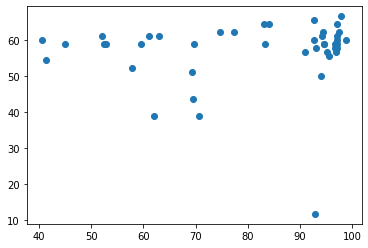

In [167]:
fig, ax = plt.subplots()
df = match_rep_df[(~match_rep_df["Batch"].str.contains("siteSub")) & (match_rep_df["sphering"] == True)]
ax.scatter(df["percent_good"], df["Percent_Replicating"], label=df["Vendor"])
fig.set_facecolor("white")

In [107]:
qc_plates = set(qc_df["Plate ID"].values)
orig_plates = set(match_rep_df[~match_rep_df["Batch"].str.contains("siteSubSample")]["Assay_Plate_Barcode"])

orig_plates ^ qc_plates


{'CP_Broad_Phenix_C_BIN1_1Plane_P1',
 'CP_Broad_Phenix_C_BIN1_1Plane_P2',
 'CP_Broad_Phenix_C_BIN1_1Plane_P3',
 'CP_Broad_Phenix_C_BIN1_1Plane_P4',
 'CP_Broad_Phenix_C_BIN1_P1',
 'CP_Broad_Phenix_C_BIN1_P2',
 'CP_Broad_Phenix_C_BIN1_P3',
 'CP_Broad_Phenix_C_BIN1_P4',
 'Plate2_PCO_6ch_9site_20XPA',
 'Plate3_PCO_6ch_4site_20XPA_Crestz',
 'Plate3_PCO_6ch_9site_20XPA_Crest',
 'Plate3_PCO_6ch_Adaptive_20XPA'}

[61.97916667] [38.88888889] BR00117060a10x
[69.27083333] [51.13636364] BR00117061a10x
[69.53125] [43.82022472] BR00117063b10x
[52.51736111] [58.88888889] BR00117062a
[57.87037037] [52.22222222] BR00117063b
[63.02083333] [61.11111111] CP_Broad_Phenix_NC_BIN1_1Plane_P1
[69.61805556] [58.88888889] CP_Broad_Phenix_NC_BIN1_1Plane_P2
[52.08333333] [61.11111111] CP_Broad_Phenix_NC_BIN1_1Plane_P3
[61.02430556] [61.11111111] CP_Broad_Phenix_NC_BIN1_1Plane_P4
[59.54861111] [58.88888889] CP_Broad_Phenix_NC_BIN1_P1
[52.86458333] [58.88888889] CP_Broad_Phenix_NC_BIN1_P2
[40.57341442] [60.] CP_Broad_Phenix_NC_BIN1_P3
[44.91746308] [58.88888889] CP_Broad_Phenix_NC_BIN1_P4
[41.29237902] [54.44444444] BRO0117059_40x


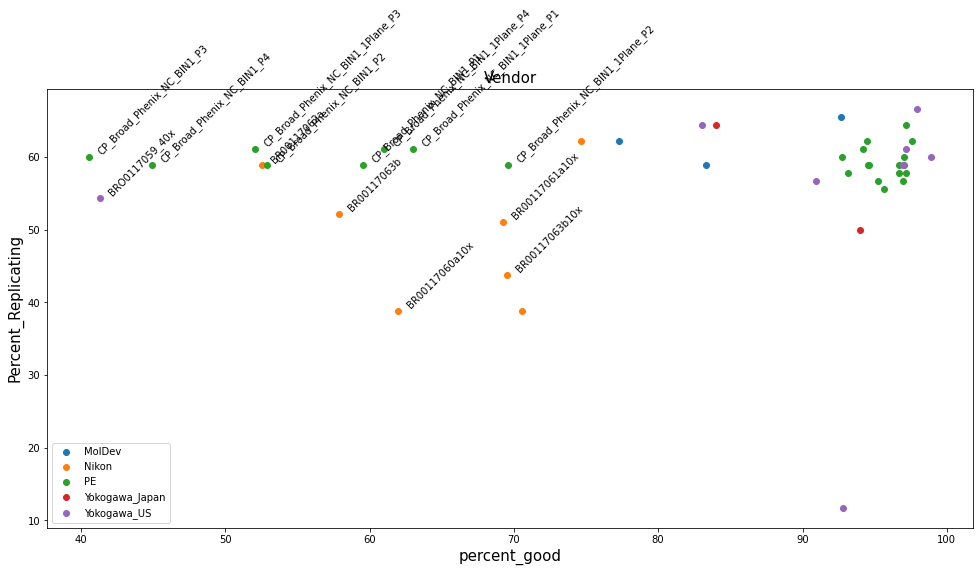

In [102]:
from matplotlib.pyplot import annotate


def group_plot(df, x, y, group, error_x=None, error_y=None, fig=None, ax=None, legend=True, label=None):
    cmap = plt.cm.tab10
    colour_palette = list()
    for i in range(cmap.N):
        colour_palette.append(cmap(i))
    
    if fig is None and ax is None:
        fig, ax = plt.subplots()
    else:
        ax = ax
    for i, (group_label, group_df) in enumerate(df.groupby(group)):
        if error_x is not None or error_y is not None:
            ax.errorbar(
                group_df.loc[:, x], 
                group_df.loc[:, y],
                xerr=group_df[error_x],
                yerr=group_df[error_y],
                ecolor=colour_palette[i],
                fmt="none",
                marker=None,
                zorder=1,
                lw=1 # Required to get error bars centered. Classic matplotlib
                )
        ax.scatter(
            group_df.loc[:, x],
            group_df.loc[:, y],
            color=colour_palette[i], 
            label=group_label,
            zorder=2
        )
        if label:
            for col, rows in label.items():
                for item in rows:
                    try:
                    # Try to add an annotation, otherwise skip it
                    # THIS FAILS IF THERE IS A DUPLICATE COL VALUES. WILL LEAD TO MULTIPLE ANNOTATIONS OVERLAYED
                        annotate_x = group_df[group_df[col] == item][x].values
                        annotate_y = group_df[group_df[col] == item][y].values
                        for i in range(len(annotate_x)):
                            print(annotate_x, annotate_y, item)
                            ax.text(annotate_x[i] + 1, annotate_y[i], item, {'ha': 'left', 'va': 'bottom'}, rotation=45, rotation_mode="anchor")
                    except:
                        pass
    ax.set_title(group, size=15)
    if legend:
        ax.legend()
    # ax.set_xscale("log")
    ax.set_xlabel(x, fontsize=15)
    ax.set_ylabel(y, fontsize=15)
    plt.tight_layout()
    fig.set_facecolor("white")
    fig.set_figheight(15)
    fig.set_figwidth(15)
    plt.subplots_adjust( 
                    wspace=0.2,
                    hspace=0.2)

# group_plot(df, "percent_good", "Percent_Replicating", "Vendor", label={"Batch": ["Scope1_Nikon_10X"]})
club_70 = df[df["percent_good"] < 70]["Assay_Plate_Barcode"].values
fig, ax = plt.subplots()
group_plot(df, "percent_good", "Percent_Replicating", "Vendor", label={"Assay_Plate_Barcode": club_70}, fig=fig, ax=ax)

[61.97916667 69.27083333 70.57291667 69.53125   ] [38.88888889 51.13636364 38.88888889 43.82022472] Scope1_Nikon_10X
[61.97916667 69.27083333 70.57291667 69.53125   ] [38.88888889 51.13636364 38.88888889 43.82022472] Scope1_Nikon_10X
[61.97916667 69.27083333 70.57291667 69.53125   ] [38.88888889 51.13636364 38.88888889 43.82022472] Scope1_Nikon_10X
[61.97916667 69.27083333 70.57291667 69.53125   ] [38.88888889 51.13636364 38.88888889 43.82022472] Scope1_Nikon_10X
[61.97916667 69.27083333 70.57291667 69.53125   ] [38.88888889 51.13636364 38.88888889 43.82022472] Scope1_Nikon_10X
[61.97916667 69.27083333 70.57291667 69.53125   ] [38.88888889 51.13636364 38.88888889 43.82022472] Scope1_Nikon_10X
[61.97916667 69.27083333 70.57291667 69.53125   ] [38.88888889 51.13636364 38.88888889 43.82022472] Scope1_Nikon_10X
[61.97916667 69.27083333 70.57291667 69.53125   ] [38.88888889 51.13636364 38.88888889 43.82022472] Scope1_Nikon_10X
[61.97916667 69.27083333 70.57291667 69.53125   ] [38.88888889 5

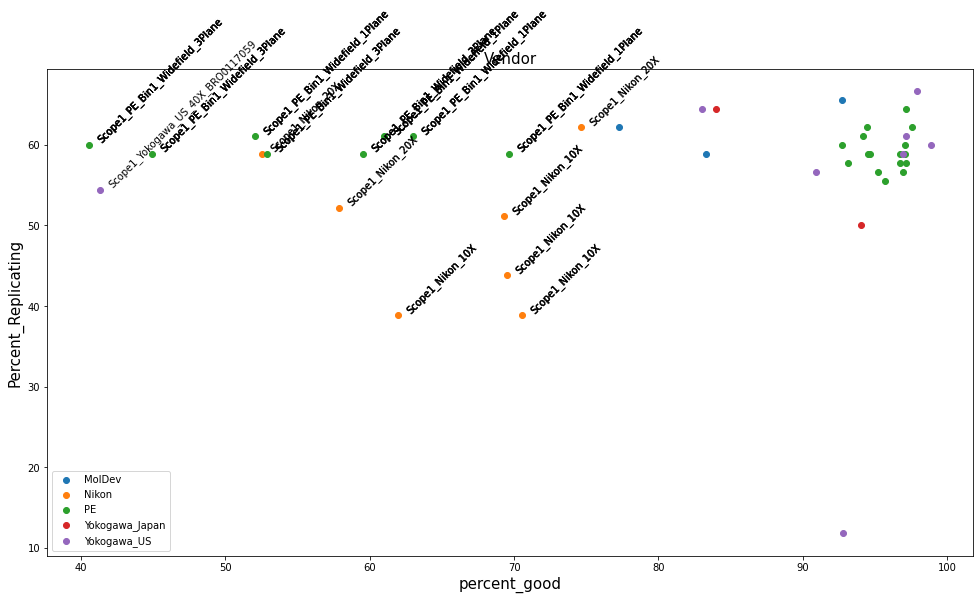

In [175]:
# group_plot(df, "percent_good", "Percent_Replicating", "Vendor", label={"Batch": ["Scope1_Nikon_10X"]})
club_70 = df[df["percent_good"] < 70]["Batch"].values
fig, ax = plt.subplots()
group_plot(df, "percent_good", "Percent_Replicating", "Vendor", label={"Batch": club_70}, fig=fig, ax=ax)

In [176]:
df

,Unnamed: 0,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled_x,Binning,Magnification,...,Percent_Replicating,value_95_replicating,sphering,cell_count,Sites-SubSampled_y,Matching,Null_Matching,Percent_Matching,value_95_matching,percent_good
254,254,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_4site_10XPA,Confocal,4,4,1,10,...,58.888889,0.195418,True,NaN,NaN,"[0.6513145239832736, 0.06431039203244439, -0.0...","[0.02243455475249815, 0.067019301870611, 0.121...",23.255814,0.309093,83.322476
256,256,MolDev,Scope1_MolDev_10X,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crest,Confocal,4,4,1,10,...,62.222222,0.264513,True,NaN,NaN,"[0.6876247243327633, 0.10229754014971497, -0.0...","[-0.03085811191138329, 0.16041790071267759, 0....",20.930233,0.401853,77.278646
258,258,MolDev,Scope1_MolDev_10X_4siteZ,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_10XPA_Crestz,Confocal,4,4,1,10,...,65.555556,0.209137,True,NaN,NaN,"[0.7131984199771768, 0.10389260202889669, -0.0...","[-0.1319700276608556, -0.017597192283266543, -...",23.255814,0.362508,92.694064
260,260,MolDev,Scope1_MolDev_20X_4site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_4site_20XPA_Crestz,Confocal,4,4,1,20,...,57.777778,0.184058,True,NaN,NaN,"[0.6156401185543268, -0.010931297539560014, -0...","[0.08267605292556449, 0.12442202268361521, 0.0...",20.930233,0.269000,NaN
262,262,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate2_PCO_6ch_9site_20XPA,Confocal,9,9,1,20,...,65.555556,0.191840,True,NaN,NaN,"[0.6293985284068596, -0.03607319828101326, -0....","[0.054126380549346806, -0.031129846436992407, ...",25.581395,0.294477,NaN
264,264,MolDev,Scope1_MolDev_20X_9site,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_9site_20XPA_Crest,Confocal,9,9,1,20,...,61.111111,0.331957,True,NaN,NaN,"[0.6801521228622807, -0.026222619470801473, -0...","[0.11159318905959048, 0.05410210789752591, 0.0...",20.930233,0.472218,NaN
266,266,MolDev,Scope1_MolDev_20X_Adaptive,JUMP-MOA_compound_platemap,Plate3_PCO_6ch_Adaptive_20XPA,Confocal,3,3,1,20,...,54.444444,0.192461,True,NaN,NaN,"[0.7590110200226707, 0.07025410531675941, 0.05...","[0.05148553910512195, -0.2455088468399666, -0....",18.604651,0.275530,NaN
268,268,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117060a10x,Widefield,1,1,1,10,...,38.888889,0.231537,True,NaN,NaN,"[0.3973580512079023, 0.04295112323820112, -0.0...",NaN,16.279070,0.356034,61.979167
270,270,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117061a10x,Widefield,1,1,1,10,...,51.136364,0.251795,True,NaN,NaN,"[0.29472093811583644, 0.04962925135224959, 0.0...","[0.16882591909695266, -0.006099792989715309, 0...",17.073171,0.336479,69.270833
272,272,Nikon,Scope1_Nikon_10X,JUMP-MOA_compound_platemap,BR00117062a10x,Widefield,1,1,1,10,...,38.888889,0.207711,True,NaN,NaN,"[0.04285430362053077, 0.07776644696728377, -0....",NaN,13.953488,0.263379,70.572917


In [78]:
df[df["percent_good"] < 70]["Assay_Plate_Barcode"].values

array(['BR00117060a10x', 'BR00117061a10x', 'BR00117063b10x',
       'BR00117062a', 'BR00117063b', 'CP_Broad_Phenix_NC_BIN1_1Plane_P1',
       'CP_Broad_Phenix_NC_BIN1_1Plane_P2',
       'CP_Broad_Phenix_NC_BIN1_1Plane_P3',
       'CP_Broad_Phenix_NC_BIN1_1Plane_P4', 'CP_Broad_Phenix_NC_BIN1_P1',
       'CP_Broad_Phenix_NC_BIN1_P2', 'CP_Broad_Phenix_NC_BIN1_P3',
       'CP_Broad_Phenix_NC_BIN1_P4', 'BRO0117059_40x'], dtype=object)

In [30]:
df[df["quality"] < 70]["Batch"]

268                     Scope1_Nikon_10X
269                     Scope1_Nikon_10X
270                     Scope1_Nikon_10X
271                     Scope1_Nikon_10X
274                     Scope1_Nikon_10X
275                     Scope1_Nikon_10X
278                     Scope1_Nikon_20X
279                     Scope1_Nikon_20X
280                     Scope1_Nikon_20X
281                     Scope1_Nikon_20X
298      Scope1_PE_Bin1_Widefield_1Plane
299      Scope1_PE_Bin1_Widefield_1Plane
300      Scope1_PE_Bin1_Widefield_1Plane
301      Scope1_PE_Bin1_Widefield_1Plane
302      Scope1_PE_Bin1_Widefield_1Plane
303      Scope1_PE_Bin1_Widefield_1Plane
304      Scope1_PE_Bin1_Widefield_1Plane
305      Scope1_PE_Bin1_Widefield_1Plane
306      Scope1_PE_Bin1_Widefield_3Plane
307      Scope1_PE_Bin1_Widefield_3Plane
308      Scope1_PE_Bin1_Widefield_3Plane
309      Scope1_PE_Bin1_Widefield_3Plane
310      Scope1_PE_Bin1_Widefield_3Plane
311      Scope1_PE_Bin1_Widefield_3Plane
312      Scope1_

In [132]:
# Add "dry" to dry-immersion column for apertures of 0.75 and 0.45


experiment_df[experiment_df["Batch"] == "Scope1_Yokogawa_US_20X_6Ch_BRO0117033"]


,Vendor,Batch,Plate_Map_Name,Assay_Plate_Barcode,Modality,Images_per_well,Sites-SubSampled,Binning,Magnification,Number_of_channels,z_plane,BF_Zplanes,Anomaly,Unnamed: 0,spinning-disc,aperture,dry-immersion,vs-brightfield,simultaneous-excitation,sites


In [258]:
# Quick edit of some columns in match_rep_df

mrdf = pd.read_csv("checkpoints/match_rep_df_NEW_PROFILES.csv")
mrdf["sites"] = mrdf["sites"].astype(int)
mrdf.to_csv("checkpoints/match_rep_df_NEW_PROFILES.csv", index=False)